In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series

import numpy as np
import matplotlib.pyplot as plt

### 设置路径

In [2]:
path_pre = '../../'
path_original_dataset = path_pre + 'original-dataset/'
path_intermediate_dataset = path_pre + 'intermediate-dataset/'

### 加载数据

In [3]:
ad = pd.read_csv(path_original_dataset + 'ad.csv')
ad.head()

,creativeID,adID,camgaignID,advertiserID,appID,appPlatform
0,4079,2318,147,80,14,2
1,4565,3593,632,3,465,1
2,3170,1593,205,54,389,1
3,6566,2390,205,54,389,1
4,5187,411,564,3,465,1


In [4]:
app_cat = pd.read_csv(path_original_dataset + 'app_categories.csv')
app_cat.head()

,appID,appCategory
0,14,2
1,25,203
2,68,104
3,75,402
4,83,203


In [5]:
ad = ad.merge(app_cat, how='left', on='appID')
ad.head()

,creativeID,adID,camgaignID,advertiserID,appID,appPlatform,appCategory
0,4079,2318,147,80,14,2,2
1,4565,3593,632,3,465,1,209
2,3170,1593,205,54,389,1,108
3,6566,2390,205,54,389,1,108
4,5187,411,564,3,465,1,209


In [6]:
del app_cat
import gc
gc.collect()

197

In [7]:
user = pd.read_hdf(path_intermediate_dataset + 'user.h5')
user.head()

,userID,age,gender,education,marriageStatus,haveBaby,hometown,residence
0,1,42,1,0,2,0,5,5
1,2,18,1,5,1,0,14,14
2,3,0,2,4,0,0,0,0
3,4,21,2,5,3,0,6,6
4,5,22,2,0,0,0,0,13


In [8]:
context = pd.read_csv(path_original_dataset + 'train.csv')
context.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator
0,0,170000,NaN,3089,2798058,293,1,1
1,0,170000,NaN,1259,463234,6161,1,2
2,0,170000,NaN,4465,1857485,7434,4,1
3,0,170000,NaN,1004,2038823,977,1,1
4,0,170000,NaN,1887,2015141,3688,1,1


In [9]:
pos = pd.read_csv(path_original_dataset + 'position.csv')
pos.head()

,positionID,sitesetID,positionType
0,2150,1,0
1,2579,1,0
2,3322,1,0
3,5726,1,0
4,4522,2,0


In [10]:
context = context.merge(pos, how='left', on='positionID')
context.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,sitesetID,positionType
0,0,170000,NaN,3089,2798058,293,1,1,0,3
1,0,170000,NaN,1259,463234,6161,1,2,0,1
2,0,170000,NaN,4465,1857485,7434,4,1,0,1
3,0,170000,NaN,1004,2038823,977,1,1,0,1
4,0,170000,NaN,1887,2015141,3688,1,1,0,1


In [11]:
del pos
gc.collect()

122

In [12]:
dataset = context.merge(user, how='left', on='userID')
del context
del user
gc.collect()
dataset = dataset.merge(ad, how='left', on='creativeID')
del ad
gc.collect()
dataset.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,sitesetID,positionType,...,marriageStatus,haveBaby,hometown,residence,adID,camgaignID,advertiserID,appID,appPlatform,appCategory
0,0,170000,NaN,3089,2798058,293,1,1,0,3,...,3,1,0,13,1321,83,10,434,1,108
1,0,170000,NaN,1259,463234,6161,1,2,0,1,...,1,0,0,2,1535,685,80,14,2,2
2,0,170000,NaN,4465,1857485,7434,4,1,0,1,...,0,0,0,15,147,460,3,465,1,209
3,0,170000,NaN,1004,2038823,977,1,1,0,1,...,0,0,0,10,411,564,3,465,1,209
4,0,170000,NaN,1887,2015141,3688,1,1,0,1,...,2,0,10,10,369,144,84,360,1,201


In [13]:
def print_value_count(df):
    d = {}
    for column in df.columns:
        d[column] = df[column].value_counts().index.size
    s = Series(d).sort_values()
    print(s)

In [14]:
print_value_count(dataset)

label                     2
appPlatform               2
gender                    3
sitesetID                 3
marriageStatus            4
telecomsOperator          4
connectionType            5
positionType              6
haveBaby                  7
education                 8
appCategory              14
residence                35
hometown                 35
appID                    50
age                      81
advertiserID             89
camgaignID              677
adID                   3447
creativeID             6315
positionID             7219
conversionTime        18206
clickTime             20160
userID              2595627
dtype: int64


creativeID, userID, positionID, adID, camgaignID 这几个需要单独考虑

camgaignID              677   
adID                   3447   
creativeID             6315   
positionID             7219   
userID              2595627   

### 统计点击次数，转化次数，转化率

In [120]:
def min_max_scaling(s):
    mx = s.max()
    mn = s.min()
    s = (s - mn) / (mx - mn)
    return s

In [121]:
def count_ratio(df, column):
    click_count_column = 'click_count_' + column
    conversion_count_column = 'conversion_count_' + column
    conversion_ratio_column = 'conversion_ratio_' + column
    
    count = DataFrame(df[column].value_counts())
    count.reset_index(inplace=True)
    count.columns = [column, click_count_column]
    
    conversion_count = DataFrame(df.loc[df['label'] == 1, column].value_counts())
    conversion_count.reset_index(inplace=True)
    conversion_count.columns = [column, conversion_count_column]
    
    count_ratio = count.merge(conversion_count, how='left', on=column)
    count_ratio[conversion_count_column].fillna(0, inplace=True)
    
    count_ratio[conversion_ratio_column] = count_ratio[conversion_count_column] / count_ratio[click_count_column]
    
    # 取对数，归一化
    for c in count_ratio.columns[1:]:
        count_ratio[c] = np.log10(count_ratio.loc[count_ratio[c] != 0, c])
        count_ratio[c] = min_max_scaling(count_ratio[c])
    
    return count_ratio

In [165]:
def count_plot(df):
    click_count_column = ''
    conversion_count_column = ''
    for c in df.columns:
        if 'click_count' in c:
            click_count_column = c
        if 'conversion_count' in c:
            conversion_count_column = c
    df.loc[df[click_count_column] != 0].plot(x=click_count_column, y=conversion_count_column, kind='scatter', figsize=(16,4))
    plt.show()

In [166]:
def count_ratio_plot(df):
    conversion_count_column = ''
    conversion_ratio_column = ''
    for c in df.columns:
        if 'conversion_ratio' in c:
            conversion_ratio_column = c
        if 'conversion_count' in c:
            conversion_count_column = c
    df.loc[df[conversion_count_column] != 0].plot(x=conversion_count_column, \
                                                  y=conversion_ratio_column, \
                                                  kind='scatter', \
                                                  figsize=(16,4))
    plt.show()

## camgaignID

In [122]:
count_ratio_camgaignID = count_ratio(dataset, 'camgaignID')

In [123]:
count_ratio_camgaignID.head()

,camgaignID,click_count_camgaignID,conversion_count_camgaignID,conversion_ratio_camgaignID
0,0.980186,1.000000,1.000000,0.573870
1,0.914784,0.918866,0.882377,0.566974
2,0.962884,0.913707,0.834382,0.515119
3,0.925147,0.898227,0.836070,0.544426
4,0.984220,0.881775,0.890582,0.642478


In [124]:
print_value_count(count_ratio_camgaignID)

conversion_count_camgaignID    150
conversion_ratio_camgaignID    425
click_count_camgaignID         502
camgaignID                     677
dtype: int64


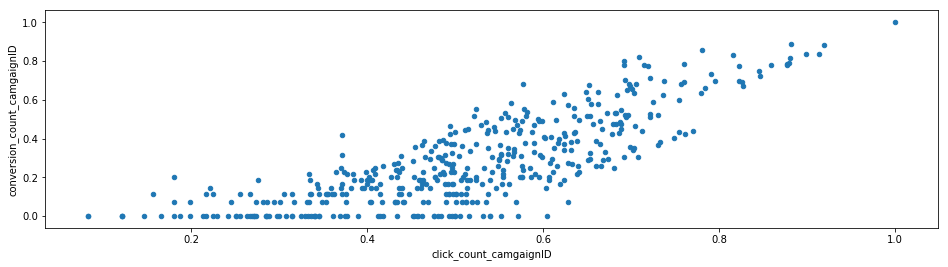

In [148]:
count_plot(count_ratio_camgaignID)

不具有明显的分段特点，故将其作为数值特征输入模型

### adID

In [149]:
count_ratio_adID = count_ratio(dataset, 'adID')

In [150]:
count_ratio_adID.head()

,adID,click_count_adID,conversion_count_adID,conversion_ratio_adID
0,0.999221,1.000000,1.000000,0.541569
1,0.991726,0.918866,0.882377,0.535061
2,0.734591,0.913707,0.834382,0.486124
3,0.903347,0.898227,0.836070,0.513783
4,0.981287,0.881775,0.890582,0.606316


In [151]:
print_value_count(count_ratio_adID)

conversion_count_adID     155
click_count_adID          813
conversion_ratio_adID     909
adID                     3447
dtype: int64


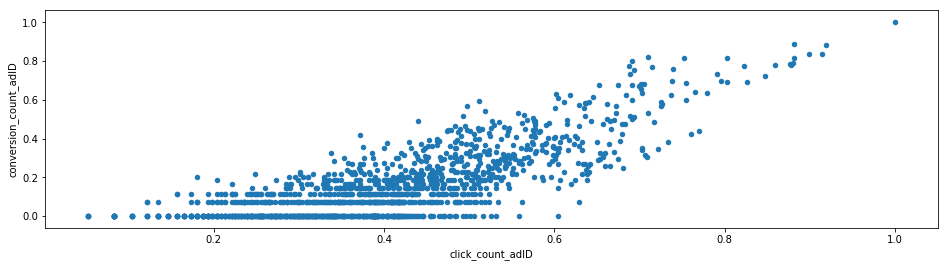

In [152]:
count_plot(count_ratio_adID)

### creativeID

In [153]:
count_ratio_creativeID = count_ratio(dataset, 'creativeID')

In [154]:
count_ratio_creativeID.head()

,creativeID,click_count_creativeID,conversion_count_creativeID,conversion_ratio_creativeID
0,0.958381,1.000000,1.000000,0.544894
1,0.972909,0.910801,0.825863,0.486477
2,0.828409,0.908279,0.870314,0.542381
3,0.674423,0.900974,0.915003,0.606316
4,0.950249,0.892586,0.816041,0.504550


In [155]:
print_value_count(count_ratio_creativeID)

conversion_count_creativeID     183
click_count_creativeID          866
conversion_ratio_creativeID    1019
creativeID                     6315
dtype: int64


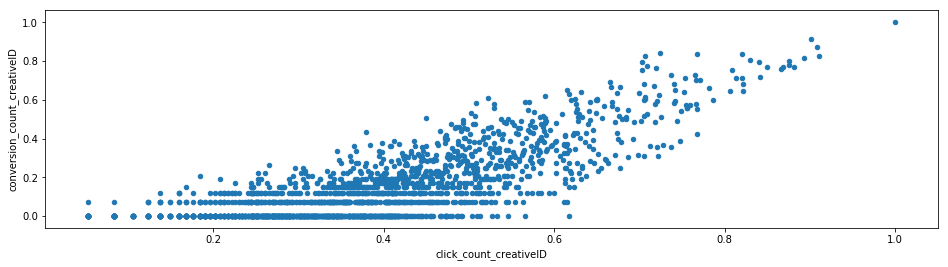

In [156]:
count_plot(count_ratio_creativeID)

### positionID

In [157]:
count_ratio_positionID = count_ratio(dataset, 'positionID')

In [158]:
count_ratio_positionID.head()

,positionID,click_count_positionID,conversion_count_positionID,conversion_ratio_positionID
0,0.878475,1.000000,1.000000,0.678628
1,0.906788,0.989650,0.968443,0.659218
2,0.858129,0.929303,0.858865,0.625830
3,0.949499,0.889564,0.596821,0.400261
4,0.918476,0.874449,0.642550,0.470353


In [159]:
print_value_count(count_ratio_positionID)

conversion_count_positionID     183
click_count_positionID          885
conversion_ratio_positionID    1035
positionID                     7219
dtype: int64


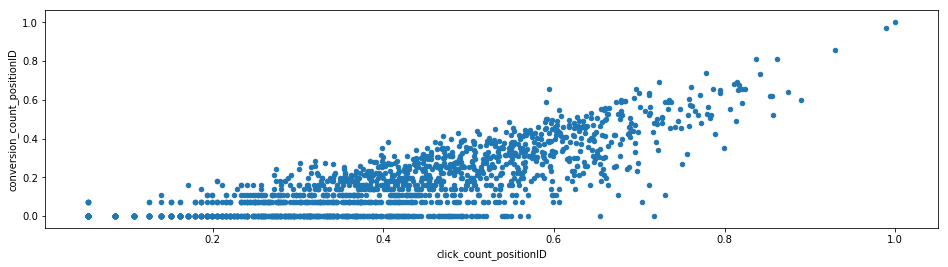

In [160]:
count_plot(count_ratio_positionID)

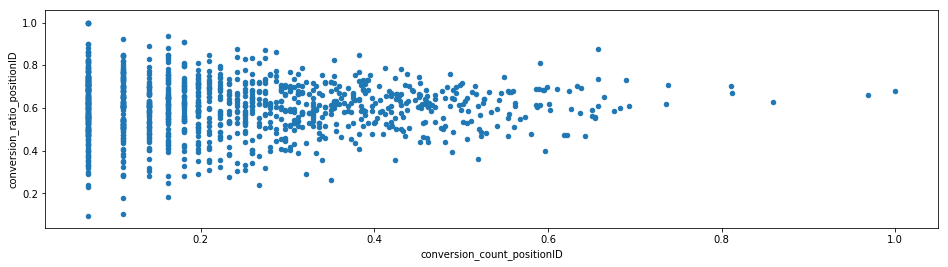

In [168]:
count_ratio_plot(count_ratio_positionID)

### userID

In [161]:
count_ratio_userID = count_ratio(dataset, 'userID')

In [162]:
count_ratio_userID.head()

,userID,click_count_userID,conversion_count_userID,conversion_ratio_userID
0,0.973214,1.000000,NaN,NaN
1,0.920789,0.976252,NaN,NaN
2,0.982939,0.969873,NaN,NaN
3,0.903960,0.942243,NaN,NaN
4,0.990989,0.924284,NaN,NaN


In [163]:
print_value_count(count_ratio_userID)

conversion_count_userID          8
conversion_ratio_userID         50
click_count_userID              68
userID                     2595627
dtype: int64


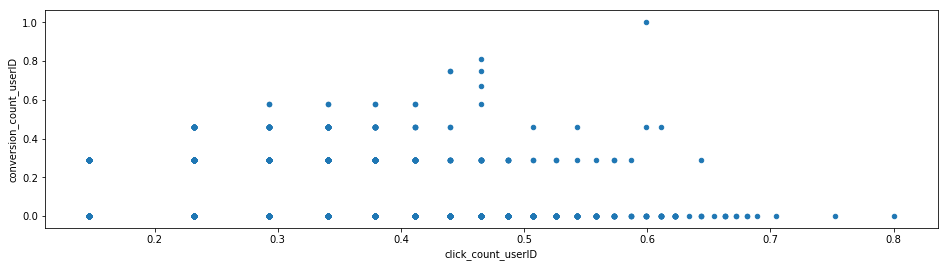

In [164]:
count_plot(count_ratio_userID)

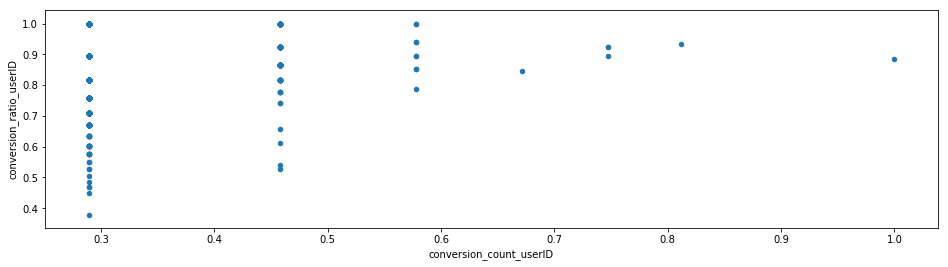

In [167]:
count_ratio_plot(count_ratio_userID)

可见 uesrID 进行单独的分段处理

### 结论

|特征|取值个数|特征本身|click_count|conversion_count|conversion_ratio|
|---|---|---|---|---|--|
|appPlatform         |      2|类别|类别|数值|数值|
|gender              |      3|类别|类别|数值|数值|
|sitesetID           |      3|类别|类别|数值|数值|
|marriageStatus      |      4|类别|类别|数值|数值|
|telecomsOperator    |      4|类别|类别|数值|数值|
|connectionType      |      5|类别|类别|数值|数值|
|positionType        |      6|类别|类别|数值|数值|
|haveBaby            |      7|类别|类别|数值|数值|
|week                |      7|类别|类别|数值|数值|
|education           |      8|类别|类别|数值|数值|
|appCategory         |     14|类别|类别|数值|数值|
|hour                |     24|类别|类别|数值|数值|
|residence           |     35|类别|类别|数值|数值|
|hometown            |     35|类别|类别|数值|数值|
|appID               |     50|类别|类别|数值|数值|
|age                 |     81|分组|分组|数值|数值|
|advertiserID        |     89|类别|类别|数值|数值|
|camgaignID          |    677|舍弃|数值|数值|数值|
|adID                |   3447|舍弃|数值|数值|数值|
|creativeID          |   6315|舍弃|数值|数值|数值|
|positionID          |   7219|舍弃|数值|数值|数值|
|userID              |2595627|舍弃|分组|数值|数值|

其中，age在数据清洗时就做过分组了，hometown和residence也是如此。userID的分组在构造特征时进行。

这三个从trainset中构造出的统计特征，与testset_ol不完全匹配   
click_count_creativeID 列有 23729 个缺失值   
conversion_count_creativeID 列有 23729 个缺失值   
conversion_ratio_creativeID 列有 23729 个缺失值   
click_count_userID 列有 272752 个缺失值   
conversion_count_userID 列有 272752 个缺失值   
conversion_ratio_userID 列有 272752 个缺失值   
click_count_positionID 列有 7996 个缺失值   
conversion_count_positionID 列有 7996 个缺失值   
conversion_ratio_positionID 列有 7996 个缺失值   
click_count_adID 列有 17497 个缺失值   
conversion_count_adID 列有 17497 个缺失值   
conversion_ratio_adID 列有 17497 个缺失值   
click_count_camgaignID 列有 4431 个缺失值   
conversion_count_camgaignID 列有 4431 个缺失值   
conversion_ratio_camgaignID 列有 4431 个缺失值   
click_count_advertiserID 列有 1355 个缺失值    
conversion_count_advertiserID 列有 1355 个缺失值   
conversion_ratio_advertiserID 列有 1355 个缺失值   

即应放弃对 creativeID，userID，positionID，adID，camgaignID，advertiserID 做这三个统计量


注意，如果不舍弃最后5天的负样本的话，情况是：
click_count_creativeID 列有 10528 个缺失值   
conversion_count_creativeID 列有 10528 个缺失值   
conversion_ratio_creativeID 列有 10528 个缺失值   
click_count_userID 列有 232349 个缺失值   
conversion_count_userID 列有 232349 个缺失值   
conversion_ratio_userID 列有 232349 个缺失值   
click_count_positionID 列有 4156 个缺失值   
conversion_count_positionID 列有 4156 个缺失值   
conversion_ratio_positionID 列有 4156 个缺失值   
click_count_adID 列有 10483 个缺失值   
conversion_count_adID 列有 10483 个缺失值  
conversion_ratio_adID 列有 10483 个缺失值   
click_count_camgaignID 列有 3199 个缺失值  
conversion_count_camgaignID 列有 3199 个缺失值  
conversion_ratio_camgaignID 列有 3199 个缺失值  
click_count_advertiserID 列有 59 个缺失值  
conversion_count_advertiserID 列有 59 个缺失值  
conversion_ratio_advertiserID 列有 59 个缺失值  
